
 # CIFAR-100 Üzerinde Derin Öğrenme Projesi

# 1-) Gerekli Kütüphanelerin Yüklenmesi

CNN projemiz için gerekli kütüphaneleri içe aktardıktan sonra GPU kullanılabilirliği kontrolü yapıyorum.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import time
import warnings
import os
warnings.filterwarnings('ignore')

# GPU kullanılabilirliğini kontrol edelim
print("TensorFlow sürümü:", tf.__version__)
print("GPU kullanılabilir mi?", "Evet" if tf.config.list_physical_devices('GPU') else "Hayır")

2025-09-24 17:45:28.819980: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758735929.011400      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758735929.069636      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow sürümü: 2.18.0
GPU kullanılabilir mi? Evet


# 2-) Model Parametrelerinin ayarlanması ve Veri Keşfi
Bu bölümde eğitim yapılandırmamı belirledim (batch=256, epoch=120, lr=1e-3, weight_decay=1e-4, model kaydı: cifar100_cnn_scratch.h5), ardından CIFAR-100 veri setini coarse (20 süper sınıf) etiketlerle yükledim; rastgele 12 eğitim görselini seçip görselleştirerek başlıklarına ilgili sınıf numaralarını yazdım ve son olarak, veri dengesini gözlemek için ilk 20 sınıfın örnek sayılarını çubuk grafikte gösterdim.

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


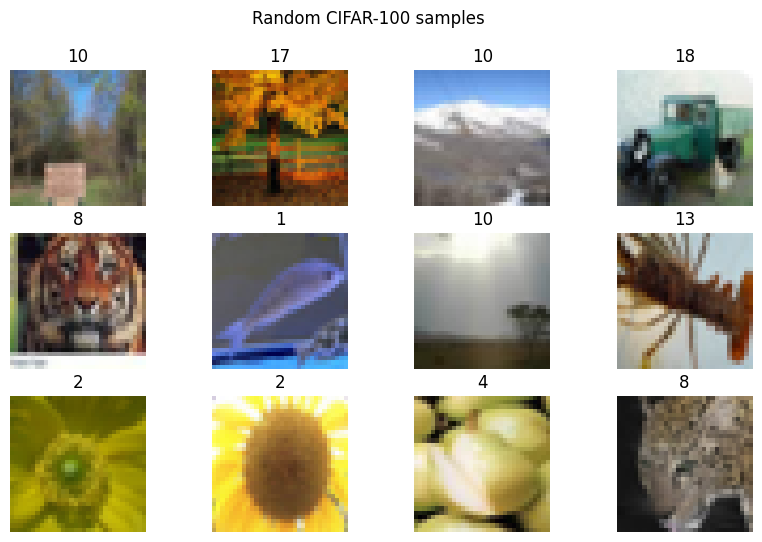

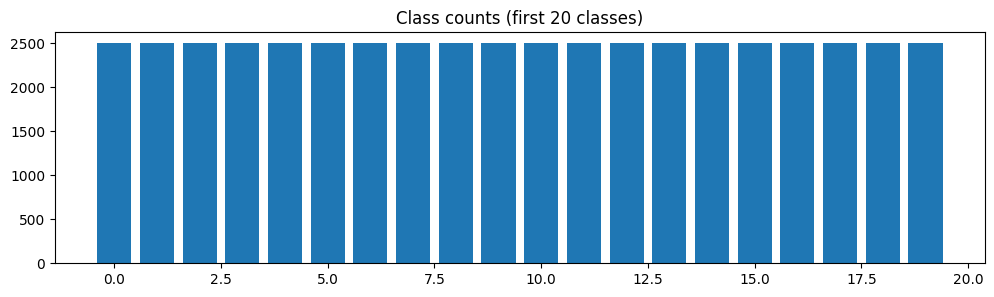

In [2]:
BATCH_SIZE = 256
EPOCHS = 120               # increase when you run for real
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
MODEL_SAVE_PATH = "cifar100_cnn_scratch.h5"

# -----------------------
# Data
# -----------------------
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data(label_mode='coarse')


plt.figure(figsize=(10,6))
for i in range(12):
    ax = plt.subplot(3,4,i+1)
    idx = np.random.randint(0, x_train.shape[0])
    plt.imshow(x_train[idx])
    plt.title(str(int(y_train[idx][0])))
    plt.axis('off')
plt.suptitle('Random CIFAR-100 samples')
plt.show()

# Class distribution
(unique, counts) = np.unique(y_train, return_counts=True)
plt.figure(figsize=(12,3))
plt.bar(unique[:20], counts[:20])
plt.title('Class counts (first 20 classes)')
plt.show()

# 3-) Veri Normalleştirmesi ve Veri Artırma

Bu bölümde görüntüleri float32’ye çevirip 255’e bölerek 0–1 aralığına normalize ettim, çıktı boyutunu sabitlemek için num_classes=100 tanımladım ve Keras ile yatay çevirme (RandomFlip), hafif döndürme (RandomRotation=0.06) ve yakınlaştırma (RandomZoom=0.08) içeren bir veri artırma hattı kurdum; ardından ilk 8 eğitim örneğinin orijinallerini üst sırada, aynı görsellerin artırılmış hallerini alt sırada göstererek dönüşümlerin beklendiği gibi çalıştığını görselleştirdim.

I0000 00:00:1758735955.769394      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


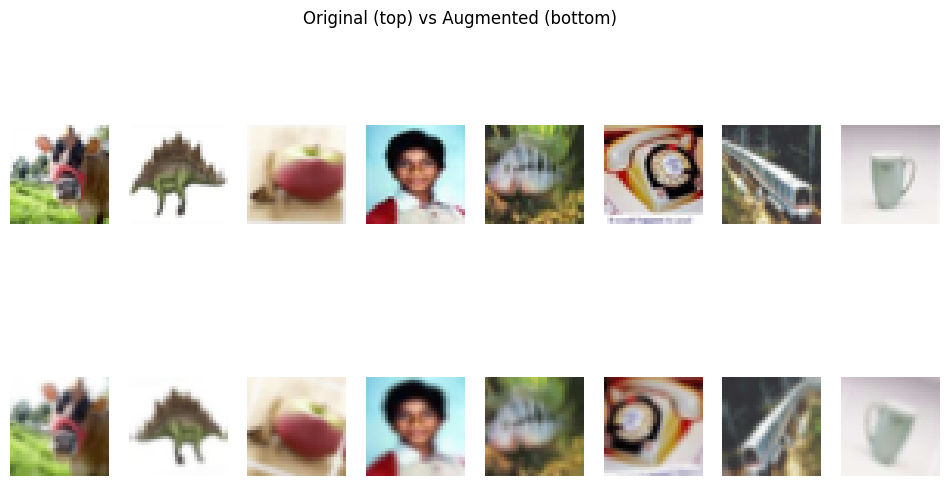

In [3]:
# Normalize
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32') / 255.0

num_classes = 100

# -----------------------
# Data augmentation (Keras layers)
# -----------------------
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.06),
    layers.RandomZoom(0.08),
], name="data_augmentation")

aug_samples = x_train[:8]
plt.figure(figsize=(12,6))
for i in range(8):
    ax = plt.subplot(2,8,i+1)
    plt.imshow(aug_samples[i])
    plt.axis('off')
    ax = plt.subplot(2,8,8+i+1)
    aug = data_augmentation(aug_samples[i:i+1])
    plt.imshow((aug[0].numpy()*255).astype('uint8'))
    plt.axis('off')
plt.suptitle('Original (top) vs Augmented (bottom)')
plt.show()

# 4-) CNN Modeli Kurulumu
Bu bölümde CIFAR-100 için sıfırdan bir CNN kurdum: girişte yalnız eğitimde çalışan data_augmentation uyguladım; ardından 3 konvolüsyon bloğu (sırasıyla 64/128/256 filtre, 3×3, padding='same', He normal başlatma, L2 (weight_decay)) kullandım ve her konv katmanından sonra BatchNorm + ReLU ekleyip blok sonlarında 2×2 MaxPooling ve artan Dropout (0.2/0.3/0.4) ile düzenlileştirdim. Tepe kısımda GlobalAveragePooling sonrası 512 nöronlu tam bağlı katman (He init + BN + ReLU + Dropout 0.5) ve softmax çıkışla num_classes boyutunda olasılıklar ürettim. Modeli make_cnn ile (adı: cifar100_cnn_scratch) oluşturdum; Adam (lr=LEARNING_RATE) ve SparseCategoricalCrossentropy kaybıyla accuracy metriğini kullanarak derledim ve son olarak model.summary() ile mimariyi doğruladım.

In [4]:
def make_cnn(input_shape=(32,32,3), num_classes=100, weight_decay=1e-4):
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)  # active during training only

    # Conv Block 1
    x = layers.Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.2)(x)

    # Conv Block 2
    x = layers.Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.3)(x)

    # Conv Block 3
    x = layers.Conv2D(256, (3,3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3,3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.4)(x)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="cifar100_cnn_scratch")
    return model

# -----------------------
# Build and compile
# -----------------------
model = make_cnn()
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer,
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "cifar100_cnn_scratch"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,333,924 (5.09 MB)

 Trainable params: 1,331,108 (5.08 MB)

 Non-trainable params: 2,816 (11.00 KB)

# 5-) Model Eğitimi ve Callback İşlemleri
Bu bölümde eğitimi güvenli ve verimli yürütmek için üç callback kullandım: ModelCheckpoint ile val_accuracy’yi izleyip en iyi modeli "best_" + MODEL_SAVE_PATH olarak kaydettim; ReduceLROnPlateau ile val_loss iyileşmeyince (patience=5) öğrenme oranını 0.5 katsayısı ile otomatik düşürdüm; EarlyStopping ile val_loss 20 epoch boyunca düzelmezse eğitimi durdurup en iyi ağırlıkları geri yükledim. Ardından model.fit ile EPOCHS ve BATCH_SIZE ayarlarıyla, verinin %10’unu doğrulama için ayırarak, callback’leri ekleyip karıştırmayı (shuffle=True) açarak eğittim ve süreci history değişkeninde kaydettim.

In [5]:
# -----------------------
# Callbacks
# -----------------------
callbacks = [
    keras.callbacks.ModelCheckpoint("best_" + MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
]

# -----------------------
# Train
# -----------------------
history = model.fit(
    x_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    callbacks=callbacks,
    shuffle=True
)


Epoch 1/120


E0000 00:00:1758735967.861866      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/cifar100_cnn_scratch_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1758735969.026187      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


176/176 ━━━━━━━━━━━━━━━━━━━━ 24s 73ms/step - accuracy: 0.1665 - loss: 3.2498 - val_accuracy: 0.1866 - val_loss: 2.9442 - learning_rate: 0.0010
Epoch 2/120
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.2915 - loss: 2.4873 - val_accuracy: 0.2766 - val_loss: 2.5568 - learning_rate: 0.0010
Epoch 3/120
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.3599 - loss: 2.2333 - val_accuracy: 0.3098 - val_loss: 2.4694 - learning_rate: 0.0010
Epoch 4/120
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.4088 - loss: 2.0589 - val_accuracy: 0.3844 - val_loss: 2.1390 - learning_rate: 0.0010
Epoch 5/120
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.4490 - loss: 1.9295 - val_accuracy: 0.4044 - val_loss: 2.1013 - learning_rate: 0.0010
Epoch 6/120
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.4811 - loss: 1.8233 - val_accuracy: 0.4856 - val_loss: 1.8135 - learning_rate: 0.0010
Epoch 7/120
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.5058 - loss: 

# 6-) Model Sonuçları ve Değerlendirme
Bu bölümde modeli test setinde değerlendirdim (yaklaşık test loss ≈ 1.00, test accuracy ≈ 0.75) ve eğitilmiş ağırlıkları "cifar100_cnn_scratch.h5" dosyasına kaydettim; ardından eğitim/validasyon kayıp ve doğruluk eğrilerini çizerek öğrenmenin gidişatını ve olası aşırı uyumu gözlemledim, test için tahminleri üretip gerçek etiketlerle karşılaştırarak karışıklık matrisini (ilk 20 sınıfın ısı haritası) görselleştirdim ve sınıf bazında precision/recall/F1 ile makro/weighted ortalama değerlerini veren classification_report çıktısını alıp modeli nicel olarak özetledim.

313/313 - 2s - 5ms/step - accuracy: 0.7504 - loss: 0.9999
Test loss: 0.9999, Test accuracy: 0.7504
Model saved to cifar100_cnn_scratch.h5


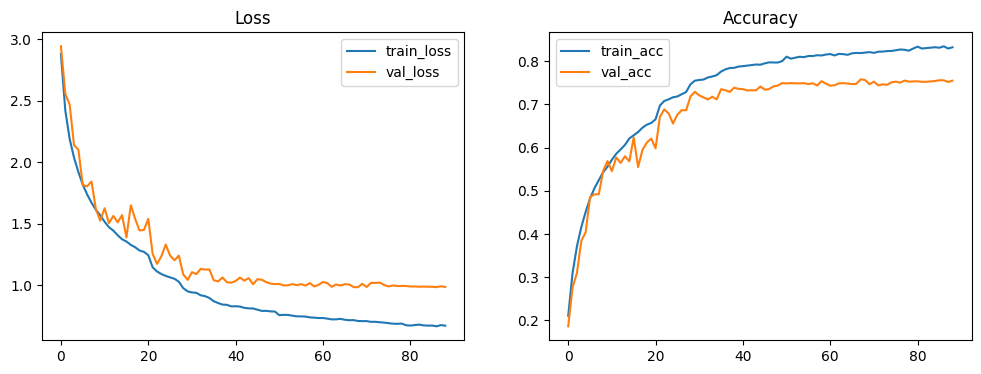

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


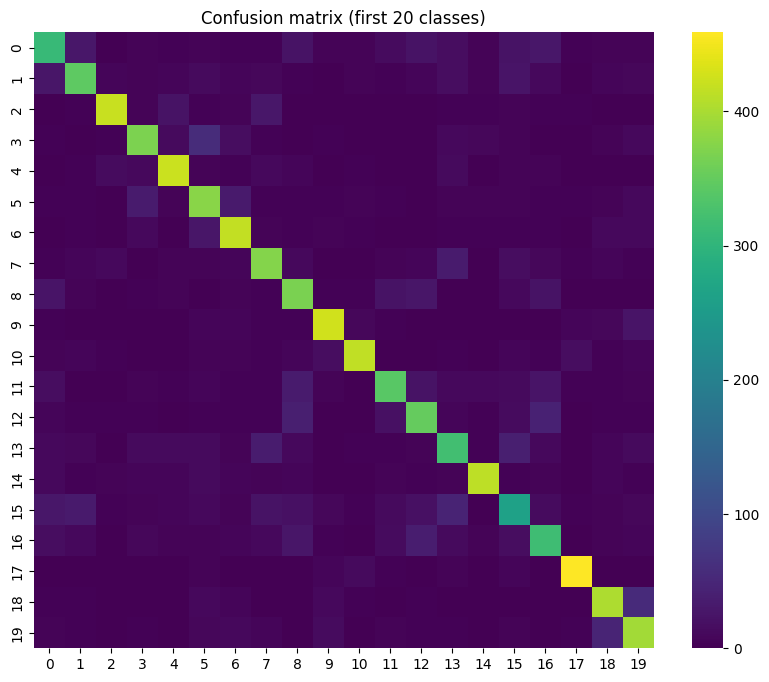

              precision    recall  f1-score   support

           0       0.67      0.62      0.64       500
           1       0.74      0.69      0.72       500
           2       0.91      0.84      0.87       500
           3       0.77      0.74      0.75       500
           4       0.82      0.85      0.83       500
           5       0.67      0.76      0.71       500
           6       0.77      0.83      0.80       500
           7       0.72      0.75      0.73       500
           8       0.66      0.73      0.69       500
           9       0.84      0.85      0.85       500
          10       0.89      0.83      0.86       500
          11       0.76      0.68      0.72       500
          12       0.70      0.70      0.70       500
          13       0.64      0.64      0.64       500
          14       0.89      0.83      0.86       500
          15       0.58      0.53      0.55       500
          16       0.64      0.63      0.64       500
          17       0.91    

In [6]:
# -----------------------
# Evaluate and save
# -----------------------
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

model.save(MODEL_SAVE_PATH)
print("Model saved to", MODEL_SAVE_PATH)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')


plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()


# Confusion matrix (subset for readability)
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report


y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = y_test.flatten()


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm[:20,:20], cmap='viridis')
plt.title('Confusion matrix (first 20 classes)')
plt.show()


print(classification_report(y_true, y_pred, zero_division=0))

# 7-) Grad-CAM Görselleştirmesi
Bu bölümde model için Grad-CAM görselleştirmesi yaptım: son konvolüsyon katmanıyla model çıkışını birlikte döndüren bir alt model kurup en yüksek olasılıklı sınıfa ait skorun bu katman aktivasyonlarına göre gradyanlarını aldım, kanalları bu gradyanların ortalamasıyla ağırlıklandırıp ısı haritasını ReLU + normalize ettim; haritayı 32×32’ye ölçekleyip renk haritası uyguladıktan sonra orijinal görüntü üzerine şeffaf biçimde bindirdim ve son konv katmanını otomatik seçerek testten bir örnek (idx=5) üzerinde orijinal ve Grad-CAM bindirmesini yan yana çizdirip modelin odaklandığı bölgeleri gösterdim.

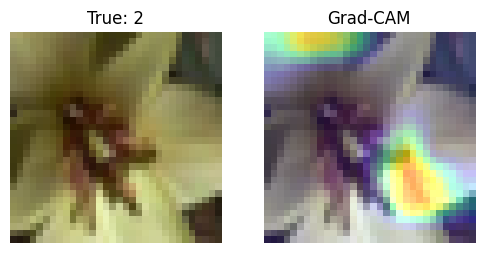

In [7]:
# Grad-CAM (robust TF→NumPy conversion, no .numpy() on ndarrays)
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # Build a model that maps the input image to the activations of the last conv layer
    # and the final predictions
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output],
    )

    # Compute the gradient of the top predicted class score w.r.t. the last conv layer outputs
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array, training=False)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)                # shape: (1, H, W, C)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))     # shape: (C,)
    conv_outputs = conv_outputs[0]                           # shape: (H, W, C)

    # Weight the channels by importance
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)   # (H, W)
    # ReLU and normalize to [0,1]
    heatmap = tf.nn.relu(heatmap)
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8)

    # Convert to NumPy only once
    heatmap = heatmap.numpy()                                 # -> ndarray (H, W)

    # Resize to input image size (32x32 for CIFAR-100)
    heatmap = cv2.resize(heatmap, (32, 32))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)    # (32,32,3), BGR
    return heatmap

# Pick the last Conv2D layer name automatically
last_conv_layer_name = None
for layer in reversed(model.layers):
    if isinstance(layer, layers.Conv2D):
        last_conv_layer_name = layer.name
        break
assert last_conv_layer_name is not None, "No Conv2D layer found in model."

# Example visualization
idx = 5
img = x_test[idx:idx+1]  # shape (1,32,32,3) in [0,1]
heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)

# Overlay heatmap onto the original image
base = (img[0] * 255).astype(np.uint8)              # RGB
heatmap_rgb = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
overlay = cv2.addWeighted(heatmap_rgb, 0.4, base, 1.0, 0)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(base); plt.title(f"True: {int(y_test[idx][0])}"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(overlay); plt.title('Grad-CAM'); plt.axis('off')
plt.show()
